In [2]:
# Import Libraries
from common.Libraries import *
# Global Config
from common.GlobalConfig import *
# Utils
from common.Utils import *
# Model
from models.BERT import bert

# Create folder if not exist
if not os.path.exists('./best_model'):
    os.makedirs('best_model')
# To show wider screen for output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

device = torch.device("cuda")
max_bert_acc = 0.7296
max_gs_acc = 0.7207
max_bay_acc = 0.7296

# Training
from torch.optim import AdamW

device = torch.device("cuda")

# 1. Helper Function

In [3]:
def train_bert(learning_rate, l2_reg, num_of_epoch=5, verbose=False, plot=False, verbose_itr=False, method='bay'):
    global output_size
    config = {
        'pretrained_model_name_or_path': 'bert-base-uncased',
        'num_labels': output_size
    }
    
    model = bert(config)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    
    model.to(device)
    total_train_acc=[]
    total_valid_acc=[]

    global max_bert_acc
    global max_gs_acc
    global max_bay_acc

    model.train()
    for e in range(num_of_epoch):    
        if verbose_itr:
            print('Epoch', e+1, flush=True)
        train_acc = 0
        train_count = 0
        train_loss = 0
        train_acc_list = []
        with tqdm.tqdm(train_loader, disable=verbose==False) as t:
            for x, y in t:
                x_ = x.to(device)
                y_ = y.to(device)
                optimizer.zero_grad()
                loss, logits = model(x_, y_)
                loss.backward()
                train_acc += (logits.argmax(axis=1) == y_.flatten()).sum()
                train_count += y.size(0)
                train_loss += loss.item() 
                optimizer.step()
                t.set_postfix({'Train loss': train_loss/train_count, 'Train acc': train_acc/train_count})
            total_train_acc.append(train_acc/train_count)
    model.eval()
    valid_acc = 0
    valid_count = 0
    valid_loss = 0
    with tqdm.tqdm(test_loader, disable=verbose==False) as t:
        for x, y in t:
            x_ = x.to(device)
            y_ = y.to(device)
            loss, logits = model(x_, y_)
            valid_acc += (logits.argmax(axis=1) == y_.flatten()).sum()
            valid_count += y.size(0)
            valid_loss += loss.item()
            t.set_postfix({'Valid loss': valid_loss/valid_count, 'Valid acc': valid_acc/valid_count})
        total_valid_acc.append(valid_acc/valid_count)
    max_val_acc = (valid_acc/valid_count).cpu().numpy()
    if method == 'grid_search':
        if max_val_acc > max_gs_acc:
            save_model(model, f'best_bert_model_grid_search_{raw_data_size}')
            max_gs_acc = max_val_acc
    else:
        if max_val_acc > max_bay_acc:
            save_model(model, f'best_bert_model_bay_{raw_data_size}')
            max_bay_acc = max_val_acc
    
    if max_val_acc > max_bert_acc:
        save_model(model, f'best_bert_model_{raw_data_size}')
        max_bert_acc = max_val_acc
    if plot:
        t = plt.plot(range(1, epochs + 1), total_train_acc, c='blue')[0]
        v = plt.plot(range(1, epochs + 1), total_valid_acc, c='green')[0]
        plt.legend([t, v], ['Train accuracy', 'Validation accuracy'])
        plt.xlabel('Epochs')
        plt.ylim(0.4, 0.8)
        plt.xticks(range(1, epochs + 1))
        plt.show()
    
    return max_val_acc

# 2. Load Data

In [4]:
train_X = np.load(f'{preprocessed_folder_path}/train_BERT_X.npy', allow_pickle=True)
train_Y = np.load(f'{preprocessed_folder_path}/train_BERT_Y.npy', allow_pickle=True)
test_X = np.load(f'{preprocessed_folder_path}/test_BERT_X.npy', allow_pickle=True)
test_Y = np.load(f'{preprocessed_folder_path}/test_BERT_Y.npy', allow_pickle=True)

tag_to_index = pd.read_csv(f'{preprocessed_folder_path}/tag_to_index.csv', index_col='tag')
index_to_tag = pd.read_csv(f'{preprocessed_folder_path}/index_to_tag.csv')
cat_to_index = pd.read_csv(f'{preprocessed_folder_path}/cat_to_index.csv', index_col='cat')
index_to_cat = pd.read_csv(f'{preprocessed_folder_path}/index_to_cat.csv')
tag_to_cat = pd.read_csv(f'{preprocessed_folder_path}/tag_to_cat.csv', index_col='tag')

output_size = len(tag_to_index)

print(f"Train input shape: {train_X.shape}")
print(f"Train label shape: {train_Y.shape}")
print(f"Test input shape: {test_X.shape}")
print(f"Test label shape: {test_Y.shape}")

Train input shape: (10800,)
Train label shape: (10800, 1)
Test input shape: (2700,)
Test label shape: (2700, 1)


In [5]:
train_loader = DataLoader(MyDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MyDataset(test_X, test_Y), batch_size=batch_size)

# 3. Hyperparameter Tuning

## 3.1 Grid Search

In [8]:
gs_param_grid = {
    'num_of_epoch': [2,3,4],
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'l2_reg': [i for i in np.arange(0.01, 0.1, 0.01)]
}
def grid_search():
    best_accuracy = 0 
    best_params = {}
    search_list = []
    i = 0
    total = 27
    for num_of_epoch in gs_param_grid['num_of_epoch']:
        for lr in gs_param_grid['learning_rate']:
            for l2 in gs_param_grid['l2_reg']:
                i = i + 1
                print(f'{i}/{total}')
                train_param = {}
                train_param = {
                  'learning_rate': lr,
                  'l2_reg': l2,
                  'num_of_epoch': num_of_epoch
                }
                train_accuracy = train_bert(**train_param, verbose=100, method='grid_search')
                if train_accuracy > best_accuracy:
                    best_accuracy = train_accuracy
                    best_params = train_param
    return best_params

In [9]:
grid_time_start = time.time()
best_gs_params = grid_search()
grid_time_end = time.time()

gs_training_time = (grid_time_end - grid_time_start)/60

1/27


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 10.76 GiB total capacity; 7.13 GiB already allocated; 40.50 MiB free; 7.46 GiB reserved in total by PyTorch)

In [15]:
# best_gs_params = {'l2_reg': 0.05, 'learning_rate': 3e-05, 'num_of_epoch': 4}
# gs_training_time = 1146.784587109089
best_gs_params, gs_training_time

({'l2_reg': 0.05, 'learning_rate': 3e-05, 'num_of_epoch': 4},
 1146.784587109089)

In [18]:
best_gs_model = load_model(f'best_bert_model_grid_search_{raw_data_size}')
y_true, y_gs_pred, y_true_cat, y_gs_pred_cat = predict_bert(best_gs_model, test_loader, index_to_tag, tag_to_cat)

# Tag accuracy
best_gs_acc = accuracy_score(y_true, y_gs_pred)
# Cat accuracy
best_gs_cat_acc = accuracy_score(y_true_cat, y_gs_pred_cat)

best_gs_acc, best_gs_cat_acc, best_gs_params

100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


(0.7207407407407408,
 0.8192592592592592,
 {'l2_reg': 0.05, 'learning_rate': 3e-05, 'num_of_epoch': 4})

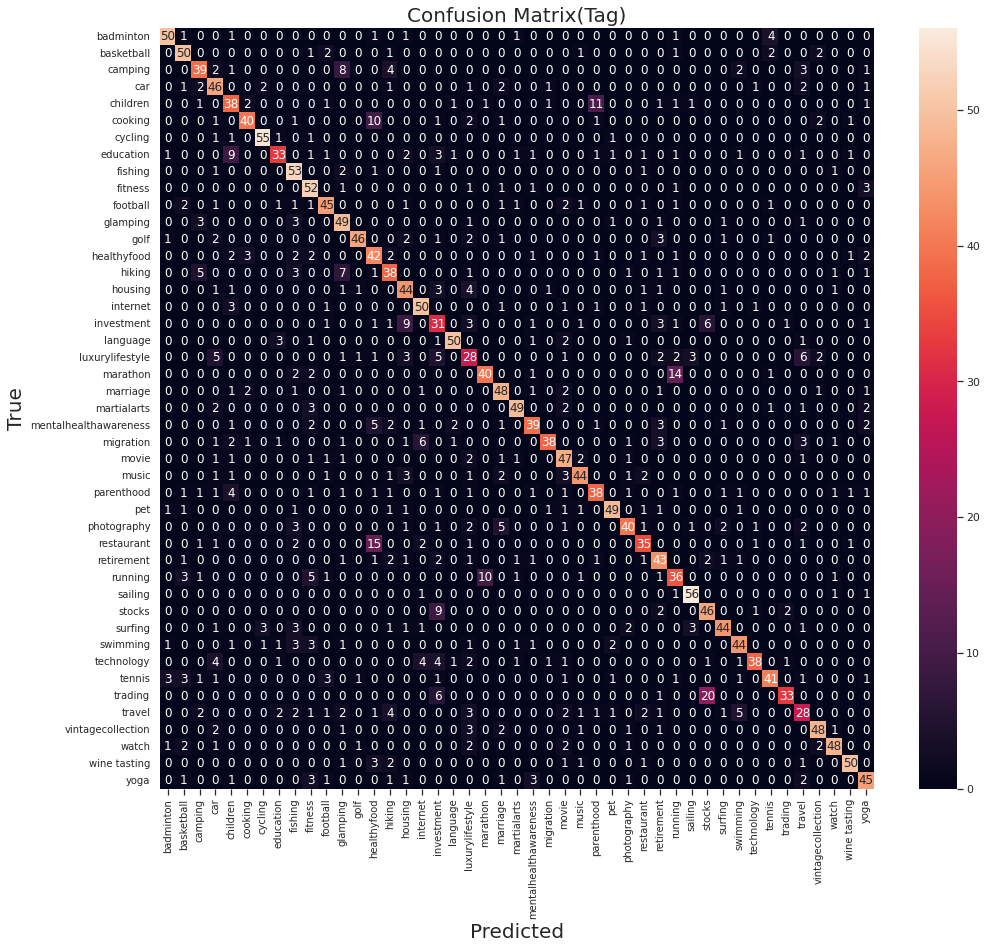

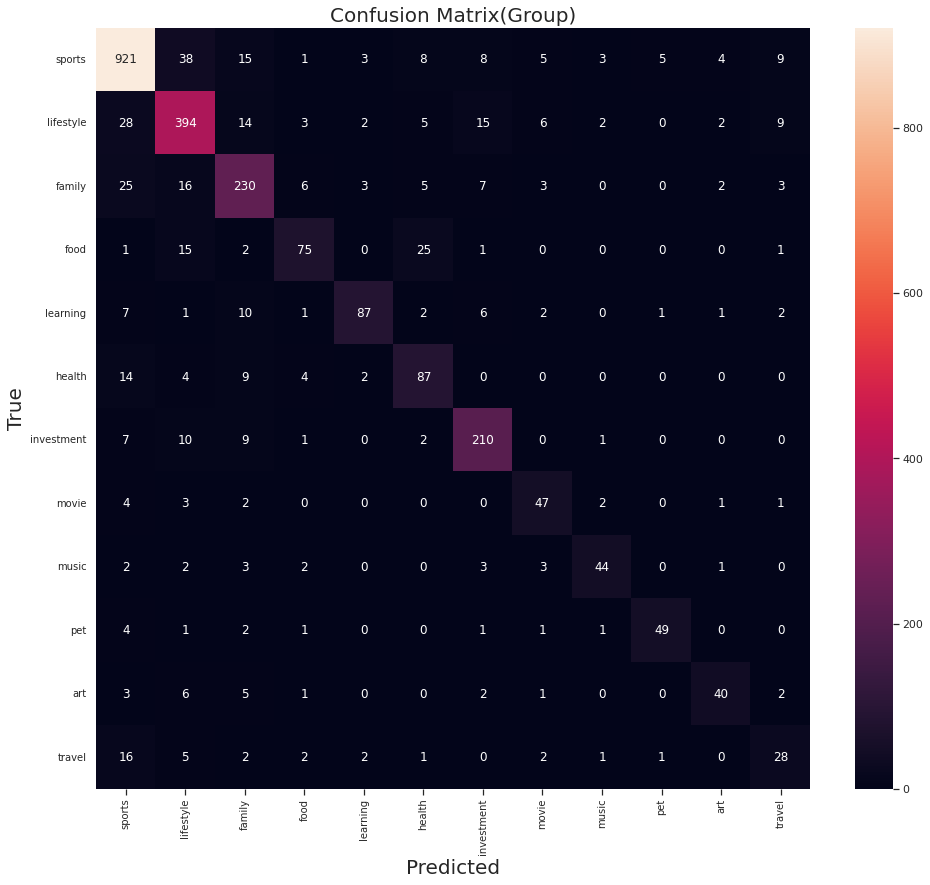

In [19]:
plot_confusion_matrix([index_to_tag['tag'][i] for i in y_gs_pred], [index_to_tag['tag'][i] for i in y_true], index_to_tag['tag'].tolist(), title='Confusion Matrix(Tag)')
plot_confusion_matrix(y_gs_pred_cat, y_true_cat, index_to_cat['cat'].tolist(), title='Confusion Matrix(Group)')

In [20]:
print_classification_report(y_gs_pred, y_true, index_to_tag['tag'].tolist(), title='Classification Report (Tag):')
print_classification_report([cat_to_index.loc[i][0] for i in y_gs_pred_cat], [cat_to_index.loc[i][0] for i in y_true_cat], index_to_cat['cat'].tolist(), title='Classification Report (Group):')

Classification Report (Tag):
                       precision    recall  f1-score   support

            badminton       0.86      0.83      0.85        60
           basketball       0.76      0.83      0.79        60
              camping       0.70      0.65      0.67        60
                  car       0.61      0.77      0.68        60
             children       0.56      0.63      0.59        60
              cooking       0.83      0.67      0.74        60
              cycling       0.90      0.92      0.91        60
            education       0.77      0.55      0.64        60
              fishing       0.66      0.88      0.76        60
              fitness       0.65      0.87      0.74        60
             football       0.76      0.75      0.76        60
             glamping       0.62      0.82      0.71        60
                 golf       0.92      0.77      0.84        60
          healthyfood       0.51      0.70      0.59        60
               hiking    

## 3.2 Bayesian Optimization

In [8]:
bayesian_time_start = time.time()

bayesian_param_grid = {
    'learning_rate': (0.00001, 0.0001), 
    'l2_reg': (0.0001, 0.01)
}

# Bounded region of parameter space
optimizer = BayesianOptimization(
    f=train_bert,
    pbounds=bayesian_param_grid,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
#     random_state=random_seed
)

optimizer.maximize(init_points=4, n_iter=16)
bayesian_time_end = time.time()

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

best_bay_params = optimizer.max['params']
bay_training_time = (bayesian_time_end - bayesian_time_start)/60

|   iter    |  target   |  l2_reg   | learni... |
-------------------------------------------------


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  1        |  0.7119   |  0.001428 |  1.413e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  2        |  0.02222  |  0.000942 |  2.864e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  3        |  0.02222  |  0.003654 |  9.596e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  4        |  0.7181   |  0.008903 |  7.396e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  5        |  0.02296  |  0.008915 |  7.625e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  6        |  0.02222  |  0.008892 |  6.827e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  7        |  0.7056   |  0.001416 |  1.271e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  8        |  0.7296   |  0.001415 |  2.397e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  9        |  0.7163   |  0.001402 |  1.918e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  10       |  0.7037   |  0.00143  |  3.243e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  11       |  0.7156   |  0.001415 |  4.076e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  12       |  0.02222  |  0.001399 |  3.704e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  13       |  0.02222  |  0.001423 |  5.42e-05 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  14       |  0.7178   |  0.001442 |  2.525e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  15       |  0.02222  |  0.001449 |  3.748e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  16       |  0.6985   |  0.001441 |  1.02e-05 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  17       |  0.02222  |  0.0089   |  8.977e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  18       |  0.7074   |  0.00146  |  1.234e-0 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  19       |  0.7122   |  0.001477 |  1.32e-05 |


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

|  20       |  0.7296   |  0.00147  |  2.477e-0 |
Iteration 0: 
	{'target': 0.7118518352508545, 'params': {'l2_reg': 0.0014278554460796804, 'learning_rate': 1.4128366651615066e-05}}
Iteration 1: 
	{'target': 0.02222222276031971, 'params': {'l2_reg': 0.000942786622502532, 'learning_rate': 2.864137469154934e-05}}
Iteration 2: 
	{'target': 0.02222222276031971, 'params': {'l2_reg': 0.0036536004711866335, 'learning_rate': 9.596064482262976e-05}}
Iteration 3: 
	{'target': 0.7181481719017029, 'params': {'l2_reg': 0.008902656261192817, 'learning_rate': 7.396238927402188e-05}}
Iteration 4: 
	{'target': 0.022962963208556175, 'params': {'l2_reg': 0.00891522241121713, 'learning_rate': 7.624978219484403e-05}}
Iteration 5: 
	{'target': 0.02222222276031971, 'params': {'l2_reg': 0.008891521339450864, 'learning_rate': 6.827410948428956e-05}}
Iteration 6: 
	{'target': 0.7055555582046509, 'params': {'l2_reg': 0.0014160205279559867, 'learning_rate': 1.2711378998196712e-05}}
Iteration 7: 
	{'target': 0.729

In [9]:
# best_bay_params = {'l2_reg': 0.0014149906817538058, 'learning_rate': 2.3965538424802775e-05, 'num_of_epoch': 5}
# bay_training_time = 459.5156059304873
best_bay_params, bay_training_time

({'l2_reg': 0.0014149906817538058, 'learning_rate': 2.3965538424802775e-05},
 459.5156059304873)

In [10]:
best_bay_model = load_model(f'best_bert_model_bay_{raw_data_size}')

y_true, y_bay_pred, y_true_cat, y_bay_pred_cat = predict_bert(best_bay_model, test_loader, index_to_tag, tag_to_cat)
# Tag accuracy
best_bay_acc = accuracy_score(y_true, y_bay_pred)
# Cat accuracy
best_bay_cat_acc = accuracy_score(y_true_cat, y_bay_pred_cat)

best_bay_acc, best_bay_cat_acc, best_bay_params

100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


(0.7296296296296296,
 0.8288888888888889,
 {'l2_reg': 0.0014149906817538058, 'learning_rate': 2.3965538424802775e-05})

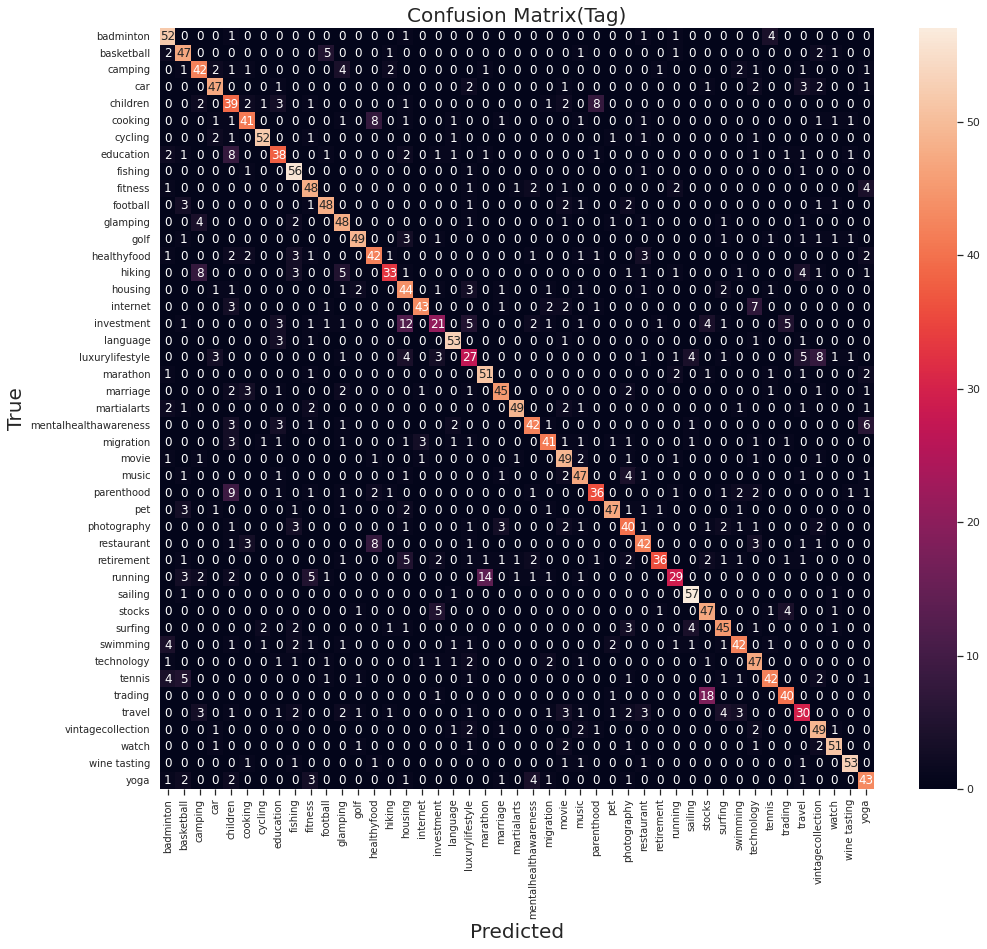

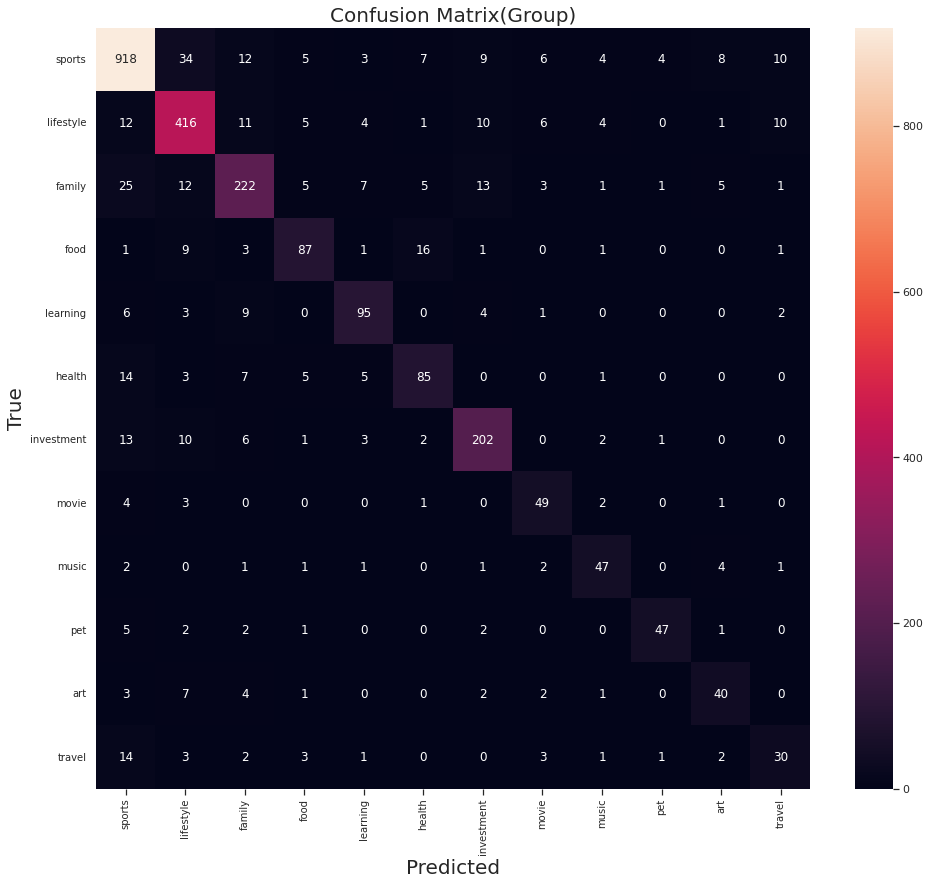

In [11]:
plot_confusion_matrix([index_to_tag['tag'][i] for i in y_bay_pred], [index_to_tag['tag'][i] for i in y_true], index_to_tag['tag'].tolist(), title='Confusion Matrix(Tag)')
plot_confusion_matrix(y_bay_pred_cat, y_true_cat, index_to_cat['cat'].tolist(), title='Confusion Matrix(Group)')

In [12]:
print_classification_report(y_bay_pred, y_true, index_to_tag['tag'].tolist(), title='Classification Report (Tag):')
print_classification_report([cat_to_index.loc[i][0] for i in y_bay_pred_cat], [cat_to_index.loc[i][0] for i in y_true_cat], index_to_cat['cat'].tolist(), title='Classification Report (Group):')

Classification Report (Tag):
                       precision    recall  f1-score   support

            badminton       0.72      0.87      0.79        60
           basketball       0.66      0.78      0.72        60
              camping       0.68      0.70      0.69        60
                  car       0.80      0.78      0.79        60
             children       0.48      0.65      0.55        60
              cooking       0.76      0.68      0.72        60
              cycling       0.91      0.87      0.89        60
            education       0.67      0.63      0.65        60
              fishing       0.74      0.93      0.82        60
              fitness       0.71      0.80      0.75        60
             football       0.81      0.80      0.81        60
             glamping       0.68      0.80      0.73        60
                 golf       0.89      0.82      0.85        60
          healthyfood       0.68      0.70      0.69        60
               hiking    

# 4. Result Summary

In [24]:
result = {
    'grid_search': {
        'training_time(mins)': gs_training_time,
        'accuracy': best_gs_acc,
        **best_gs_params
    },
    'bayesian': {
        'training_time(mins)': bay_training_time,
        'accuracy': best_bay_acc,
        **best_bay_params
    },
}

In [25]:
result = pd.DataFrame.from_dict(result)
result

,grid_search,bayesian
training_time(mins),1146.784587,459.515606
accuracy,0.720741,0.729630
l2_reg,0.050000,0.001415
learning_rate,0.000030,0.000024
num_of_epoch,4.000000,5.000000
